Much of this code is borrowed from here: https://jkzorz.github.io/2019/07/08/mantel-test.html

# IBD Scatter plot

### Importing modules

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import numpy as np

### Loading data

In [48]:
df_fst = pd.read_csv('../tables/pairwise_fst_apriori')
meta = pd.read_csv('../config/meta_apriori.csv')
bam = pd.read_table('../data/merged_bams/bams_4_rcr.txt', header=None)

# Subset to only include samples in STRUCTURE analysis
bam.columns = ['Sample_ID']
bam['Sample_ID'] = bam['Sample_ID'].apply(lambda x: x.split('/')[-1].split('.')[0])
meta = pd.merge(meta, bam, on='Sample_ID')
meta

,Unnamed: 0,Sample_ID,latitude,longitude,is_replicate,replicate,library,barcode,id,POP
0,0,ucin001,39.143365,-92.695926,False,NaN,14,ACCA,ucin001,MO
1,1,ucin002,37.885845,-90.161531,False,NaN,15,ACCA,ucin002,MO
2,2,ucin003,37.824835,-92.207022,False,NaN,16,ACCA,ucin003,MO
3,3,ucin004conc,38.935162,-91.465437,False,NaN,9,AGTG,ucin004conc,MO
4,4,ucin005,37.885845,-90.161531,False,NaN,10,AGTG,ucin005,MO
...,...,...,...,...,...,...,...,...,...,...
239,333,ucin432z,47.578635,-92.514570,False,NaN,33,GTGT,ucin432z,MN_WI_ND
240,334,ucin433,47.578635,-92.514570,False,NaN,33,AGAC,ucin433,MN_WI_ND
241,335,ucin434,41.002049,-93.274419,False,NaN,33,ACCA,ucin434,IA_NE
242,336,ucin435,41.822100,-90.578000,False,NaN,33,AGTG,ucin435,IA_NE


### Find population average location 

In [50]:
def calculate_centroid(group):
    return pd.Series({'latitude': group['latitude'].values.mean(), 
                      'longitude': group['longitude'].values.mean()})

In [52]:
average_pop_locations = meta.groupby('POP').apply(calculate_centroid)
average_pop_locations

,latitude,longitude
POP,,
AR,34.999968,-93.032889
IA_NE,41.714274,-93.171332
IL_IN,38.674011,-86.838045
KS_OK,36.232095,-95.595100
KY_TN,37.113864,-85.540890
LA,30.863437,-91.798717
MI,43.299231,-84.304328
MN_WI_ND,46.044525,-92.167364
MO,37.837973,-91.525069


### Manipulate dataframes

In [59]:
df_fst['pop1'] = df_fst.index
df_fst_melt = pd.melt(df_fst, id_vars='pop1', var_name='pop2', value_name='Fst' )
df_fst_melt

,pop1,pop2,Fst
0,AR,AR,NaN
1,IA_NE,AR,0.0504
2,IL_IN,AR,0.0387
3,KS_OK,AR,0.0056
4,KY_TN,AR,0.0316
...,...,...,...
139,MN_WI_ND,SC_NC,0.0902
140,MO,SC_NC,0.0577
141,MS,SC_NC,0.0459
142,OH_WV,SC_NC,0.0517


### Calculate distance between pops

In [63]:
def calculate_distance(pop1, pop2):
    
    pop_1_df = meta.loc[meta.POP == pop1]
    center_pop1 = (pop_1_df['latitude'].mean(), pop_1_df['longitude'].mean())
    
    pop_2_df = meta.loc[meta.POP == pop2]
    center_pop2 = (pop_2_df['latitude'].mean(), pop_2_df['longitude'].mean())
    
    return geodesic(center_pop1, center_pop2).km

In [65]:
df_fst_melt['geo_distance'] = df_fst_melt.apply(lambda x: 
                               calculate_distance(x.pop1, x.pop2), axis=1)

### Adjusting to make relationship linear

In [69]:
df_fst_melt['fst_adj'] =  df_fst_melt['Fst'] / (1 - df_fst_melt['Fst']) 
df_fst_melt['ln_dist'] = np.log(df_fst_melt['geo_distance'])
df_fst_melt = df_fst_melt.loc[df_fst_melt.pop1 != df_fst_melt.pop2]
df_fst_melt

/tmp/ipykernel_2813866/2766818262.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fst_melt['fst_adj'] =  df_fst_melt['Fst'] / (1 - df_fst_melt['Fst'])
/tmp/ipykernel_2813866/2766818262.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fst_melt['ln_dist'] = np.log(df_fst_melt['geo_distance'])


,pop1,pop2,Fst,geo_distance,fst_adj,ln_dist
1,IA_NE,AR,0.0504,745.409710,0.053075,6.613934
2,IL_IN,AR,0.0387,686.444471,0.040258,6.531525
3,KS_OK,AR,0.0056,269.381127,0.005632,5.596127
4,KY_TN,AR,0.0316,714.360567,0.032631,6.571388
5,LA,AR,0.0102,473.039726,0.010305,6.159179
...,...,...,...,...,...,...
138,MI,SC_NC,0.0484,1079.884053,0.050862,6.984609
139,MN_WI_ND,SC_NC,0.0902,1711.616305,0.099143,7.445193
140,MO,SC_NC,0.0577,1227.387305,0.061233,7.112643
141,MS,SC_NC,0.0459,1059.866558,0.048108,6.965898


### Plotting

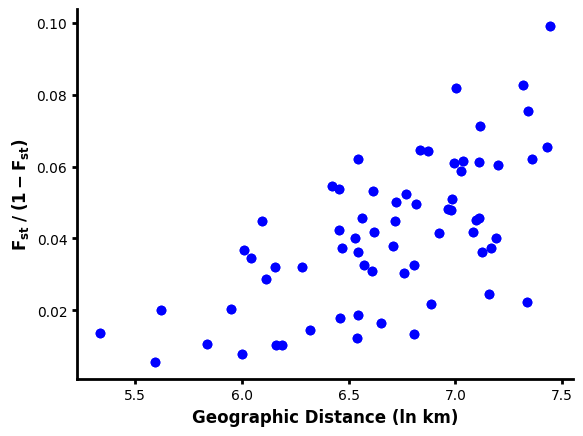

In [72]:
fig, ax = plt.subplots()
ax.scatter(x=df_fst_melt['ln_dist'], y=df_fst_melt['fst_adj'], color='blue')
ax.set_xlabel('Geographic Distance (ln km)', fontname='Arial', fontweight='bold', fontsize=12 )
ax.set_ylabel('$\mathbf{F_{st} \; / \; (1-F_{st})}$', fontname='Arial', fontsize=12, fontweight='bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.tick_params(axis='both', width=2)

# Mantel test

### Loading R magic

In [16]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


### Loading libraries

In [32]:
%%R
library('vegan')
library('dplyr')
library("geosphere")
library("tibble")

### Building geographic distance matrix
Loading data, and computing average location for each sample population

In [33]:
%%R
meta_df = read.csv('../config/meta_apriori_jittered.csv', row.names=1, header=TRUE)
pop_loc_df = meta_df %>% group_by(POP) %>% summarize(
    avg_latitude = mean(latitude, na.rm = TRUE),
    avg_longitude = mean(longitude, na.rm = TRUE)
) %>% select(c('POP','avg_longitude','avg_latitude')) %>% column_to_rownames(var = 'POP')
pop_loc_df

         avg_longitude avg_latitude
AR           -92.96603     34.86654
IA_NE        -93.26722     41.91099
IL_IN        -87.18501     38.73104
KS_OK        -95.42498     36.44381
KY_TN        -85.12533     37.17121
LA           -91.74622     30.82701
MI           -84.29672     43.26454
MN_WI_ND     -91.97053     45.93040
MO           -91.43789     37.73714
MS           -89.46244     32.35175
OH_WV        -82.19012     39.40282
SC_NC        -78.43982     34.76582


Building distance matrix

In [36]:
%%R
d.geo = distm(pop_loc_df, fun=distHaversine)
rownames(d.geo) <- rownames(pop_loc_df)
colnames(d.geo) <- rownames(pop_loc_df)
dist.geo = as.dist(d.geo)
dist.geo

                AR     IA_NE     IL_IN     KS_OK     KY_TN        LA        MI
IA_NE     784623.5                                                            
IL_IN     671015.1  625675.2                                                  
KS_OK     283349.7  636387.4  769822.6                                        
KY_TN     750836.7  875067.1  250662.4  921095.0                              
LA        463910.1 1241311.3  973343.6  712019.4  933325.6                    
MI       1196659.5  750090.0  559883.5 1215080.8  681943.4 1533020.0          
MN_WI_ND 1234482.8  459341.5  892543.1 1094683.4 1128563.9 1681413.9  676407.6
MO        347705.4  490212.4  387938.2  382155.7  561276.3  769753.8  861912.6
MS        428750.7 1116091.5  739418.9  712084.8  667011.4  275135.0 1296286.7
OH_WV    1080398.5  975413.1  438074.7 1206672.3  357015.5 1290142.6  464506.4
SC_NC    1326461.7 1516214.6  895676.7 1546565.0  658956.8 1318797.0 1072469.9
          MN_WI_ND        MO        MS     OH_WV
IA_

### Importing pairwise Fst matrix (from *hierfstat*)

In [37]:
%%R
fst_df = read.csv('../tables/pairwise_fst_apriori', row.names=1, header=TRUE)
dist.fst = as.dist(fst_df)
dist.fst

             AR  IA_NE  IL_IN  KS_OK  KY_TN     LA     MI MN_WI_ND     MO
IA_NE    0.0504                                                          
IL_IN    0.0387 0.0510                                                   
KS_OK    0.0056 0.0361 0.0365                                            
KY_TN    0.0316 0.0478 0.0135 0.0316                                     
LA       0.0102 0.0432 0.0213 0.0121 0.0131                              
MI       0.0401 0.0401 0.0142 0.0350 0.0183 0.0217                       
MN_WI_ND 0.0666 0.0101 0.0606 0.0554 0.0579 0.0615 0.0584                
MO       0.0104 0.0279 0.0335 0.0077 0.0310 0.0161 0.0296   0.0473       
MS       0.0430 0.0576 0.0300 0.0438 0.0175 0.0197 0.0361   0.0702 0.0406
OH_WV    0.0457 0.0605 0.0356 0.0437 0.0199 0.0240 0.0310   0.0756 0.0430
SC_NC    0.0571 0.0764 0.0497 0.0584 0.0349 0.0385 0.0484   0.0902 0.0577
             MS  OH_WV
IA_NE                 
IL_IN                 
KS_OK                 
KY_TN               

### Running mantel test

In [39]:
%%R
mantel_out = mantel(dist.geo, dist.fst, method='spearman', permutations = 9999)
mantel_out


Mantel statistic based on Spearman's rank correlation rho 

Call:
mantel(xdis = dist.geo, ydis = dist.fst, method = "spearman",      permutations = 9999) 

Mantel statistic r: 0.608 
      Significance: 1e-04 

Upper quantiles of permutations (null model):
  90%   95% 97.5%   99% 
0.212 0.268 0.320 0.365 
Permutation: free
Number of permutations: 9999

